In [1]:
import pandas as pd
from collections import Counter
from pathlib import Path

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
MODEL_CACHE = Path("/mnt/storage/model_cache/torch")

for child in INPUT_PATH.iterdir():
    print(child)

/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/mlm_data_val.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/pretrain_text.txt
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/test.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/mlm_data.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/sample_submission.csv
/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize/train.csv


In [2]:
df = pd.read_csv(INPUT_PATH / "train.csv")
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
df.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


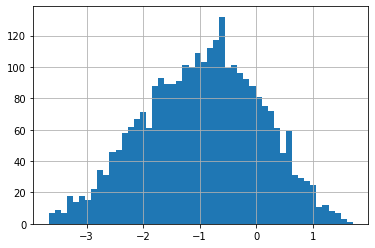

In [4]:
df["target"].hist(bins=50);

In [5]:
str(df.loc[0, "excerpt"])

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

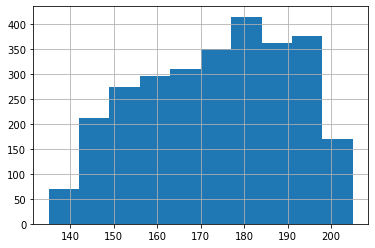

In [6]:
df["word_count"] = df['excerpt'].str.split().apply(len)
df["word_count"].hist();

In [7]:
df["url_legal"].value_counts()

https://www.africanstorybook.org/                                                                       118
https://www.africanstorybook.org/#                                                                       46
https://simple.wikipedia.org/wiki/Voltage                                                                 2
https://emedia.uen.org/courses/utah-oer-textbooks-3rd-grade-seed/view                                     1
https://www.commonlit.org/texts/who-gets-to-be-president                                                  1
                                                                                                       ... 
https://freekidsbooks.org/wp-content/uploads/2019/09/Why-Cant-We-Glow-Like-Fireflies-FKB-Stories.pdf      1
https://freekidsbooks.org/wp-content/uploads/2019/12/ELA_Grade2_Unit4_Workbook_engageNY-FKB.pdf           1
https://en.wikipedia.org/wiki/Earthquake_valve                                                            1
https://simple.wikipedia.org

# Huggingface

In [14]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
import sys

sys.path.append("/home/anjum/kaggle/commonlitreadabilityprize/")

from src.tokenizers import SentencePieceTokenizer

In [11]:
model_name = "google/bigbird-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=MODEL_CACHE)

# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     cache_dir=MODEL_CACHE,
# #     num_labels=1,
# #     output_hidden_states=True,
# )

model = AutoModel.from_pretrained(
    model_name,
    cache_dir=MODEL_CACHE,
#     num_labels=1,
#     output_hidden_states=True,
)

model

ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [28]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt", return_token_type_ids=True)
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs)

In [29]:
outputs  #["logits"]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0478,  0.0886, -0.0098,  ..., -0.0544, -0.0672, -0.0039],
         [-0.0712,  0.0150, -0.1299,  ...,  0.0638,  0.0296, -0.0860],
         [ 0.0906,  0.1437,  0.0828,  ...,  0.0509, -0.0320, -0.0490],
         ...,
         [ 0.0853,  0.2155,  0.0849,  ..., -0.1150,  0.0330, -0.0790],
         [ 0.1679,  0.1288,  0.0065,  ...,  0.0367, -0.0631,  0.0276],
         [-0.0436,  0.0892, -0.0389,  ..., -0.0957, -0.0744, -0.0284]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-3.2083e-03, -2.1940e-01, -2.1088e-01, -7.6721e-02,  1.2052e-01,
          2.0488e-01,  2.6070e-01, -8.4343e-02, -7.2521e-02, -1.7025e-01,
          2.1089e-01, -2.1008e-02, -8.2023e-02,  1.0177e-01, -1.4424e-01,
          4.9201e-01,  2.1202e-01, -4.5743e-01,  3.5992e-02, -1.5410e-02,
         -2.7218e-01,  8.2779e-02,  4.7006e-01,  3.3553e-01,  1.1576e-01,
          6.0713e-02, -1.3375e-01, -1.2829e-02,  1.8398e-01,  2.2060

# Folds

In [11]:
inputs

{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
outputs[1].shape

IndexError: tuple index out of range

In [19]:
for name, param in model.named_parameters():
    print(name)

roberta.embeddings.word_embeddings.weight
roberta.embeddings.position_embeddings.weight
roberta.embeddings.token_type_embeddings.weight
roberta.embeddings.LayerNorm.weight
roberta.embeddings.LayerNorm.bias
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.0.attention.self.query.bias
roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.0.attention.self.key.bias
roberta.encoder.layer.0.attention.self.value.weight
roberta.encoder.layer.0.attention.self.value.bias
roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.attention.output.dense.bias
roberta.encoder.layer.0.attention.output.LayerNorm.weight
roberta.encoder.layer.0.attention.output.LayerNorm.bias
roberta.encoder.layer.0.intermediate.dense.weight
roberta.encoder.layer.0.intermediate.dense.bias
roberta.encoder.layer.0.output.dense.weight
roberta.encoder.layer.0.output.dense.bias
roberta.encoder.layer.0.output.LayerNorm.weight
roberta.encoder.layer.0.output.LayerNorm

In [25]:
model.

<bound method Module.named_children of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_feature

In [26]:
model.roberta.parameters()

TypeError: unsupported operand type(s) for +: 'generator' and 'generator'

In [18]:
clf_params = [param for name, param in model.named_parameters() if name.startswith("classifier")]
clf_params

[Parameter containing:
 tensor([[-0.0021,  0.0051, -0.0325,  ..., -0.0270,  0.0057,  0.0049],
         [-0.0094, -0.0157,  0.0309,  ..., -0.0360,  0.0347,  0.0074],
         [-0.0193, -0.0328, -0.0298,  ...,  0.0261,  0.0075, -0.0067],
         ...,
         [-0.0226,  0.0168, -0.0352,  ..., -0.0125,  0.0174, -0.0036],
         [-0.0140,  0.0131,  0.0080,  ..., -0.0112,  0.0454, -0.0104],
         [ 0.0108,  0.0106, -0.0346,  ...,  0.0383,  0.0252,  0.0271]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,